# Lotka-Volterra example: the permanent case

## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min \int_0^T \mathbb{1}_{K^c}(x(t), y(t)) dt, \\[0.5em]
        \dot{x}(t)  = x(t)(r - y(t)), \\[0.5em]
        \dot{y}(t)  = y(t)(x(t) - m - u(t)),  \\[0.5em]
        u(t) \in [0, u_{\mathrm{max}}],\\[0.5em]
        (x(0),y(0)) = (x_0,y_0),
    \end{array}
    \right.
$$

with $K$ denotes $\{(x,y) \mid x\geq s\}$ with $u_{\mathrm{max}}+m< s $.


## Definition of the regularized optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min z(T), \\[0.5em]
        \dot{x}(t)  = x(t)(r - y(t)), \\[0.5em]
        \dot{y}(t)  = y(t)(x(t) - m - u(t)),  \\[0.5em]
        \dot{z}(t)  = f_{\mathrm{reg}}(x(t), y(t)),  \\[0.5em]
        u(t) \in [0, u_{\mathrm{max}}],\\[0.5em]
        (x(0),y(0), z(0)) = (x_0,y_0,0),
    \end{array}
    \right.
$$

where $f_{\mathrm{reg}}$ is a regularization of $\mathbb{1}_{K^c}(x(t), y(t)) = \mathbb{1}_{\{(x,y) \mid x < s\}}(x(t), y(t))$

In [1]:
# For direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving
# To plot solutions
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct Directsolution
    t; x; y ; z ; u  
end

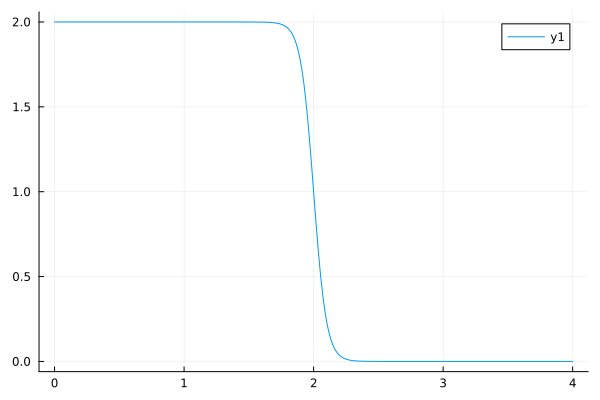

In [7]:
function F(x, alpha, s)
    return tanh(alpha * (x - s))
end

f(x) = 1 - F(x, 10, 2.) ; 
plot(f, 0. , 4.)

### Direct method

In [8]:
function LV(x0, tf, m, r, s, umax, alpha, ϵ; solution=[], nsteps=500, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",700)

    N     = nsteps     # Grid size
    
    uumax = umax

    @variables(sys, begin
                x[1:N+1]    
                y[1:N+1]   
                z[1:N+1]   
          0. ≤  u[1:N+1]  ≤ uumax
    end)
    
    T  = tf
    
    Δt = T/N 


    # Objective
    @objective(sys, Min, z[N+1])

    # Boundary constraints
    @constraints(sys, begin
        con_x10, x[1]    == x0[1] 
        con_x20, y[1]    == x0[2] 
        con_x30, z[1]    == 0.0
        end)
        
    rr     = r
    
    mm     = m
    
    ss     = s
    
    eps    = ϵ
    
    alphaa = alpha
        
    # Dynamics
    @NLexpression(sys, dx[j = 1:N+1] ,  x[j]*(rr - eps*y[j]) )
    @NLexpression(sys, dy[j = 1:N+1] ,  y[j]*(eps*x[j] - mm - u[j]) )
    @NLexpression(sys, dz[j = 1:N+1] ,  1. - F(x[j], alphaa, ss) )
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx[j=1:N] , x[j+1]  == x[j] + 0.5 * Δt * (dx[j+1] + dx[j])
        con_dy[j=1:N] , y[j+1]  == y[j] + 0.5 * Δt * (dy[j+1] + dy[j])
        con_dz[j=1:N] , z[j+1]  == z[j] + 0.5 * Δt * (dz[j+1] + dz[j])

        end)

 

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x  = value.(x)[:]
    y  = value.(y)[:]
    z  = value.(z)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)

  
    return Directsolution(t , x , y , z , u )
end;

In [9]:
# Resolution

x0    = [0.4; 0.]

tf    = 10        #final time
m     = 1
r     = 1
s     = 2.       #interface 
umax  = 1.5        #control bound u_max
alpha = 10.       #regularization parameter
ϵ     = 1.        #continuation

sol = LV(x0, tf, m, r, s, umax, alpha, ϵ, nsteps=500);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     7003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1503
Total number of in

  (Local) solution found
  objective value = 3.216703430254473



┌ Warning: Function F automatically registered with 3 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :F, 3, F; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


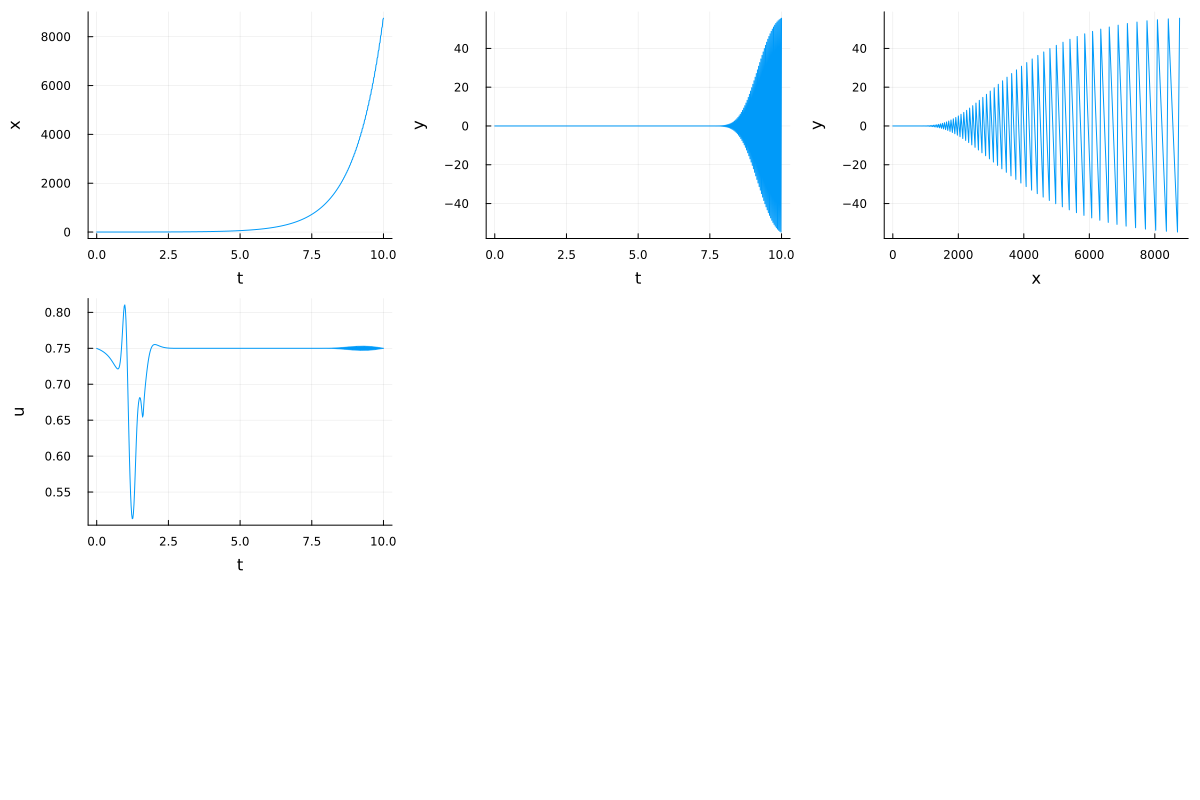

In [10]:
# Plots
t  = sol.t
x  = sol.x
y  = sol.y
z  = sol.z
u  = sol.u


x_plot   = plot(t, x,  xlabel = "t", ylabel = "x",  legend = false)
y_plot   = plot(t, y,  xlabel = "t", ylabel = "y",  legend = false)
z_plot   = plot(t, z,  xlabel = "t", ylabel = "z",  legend = false)

u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)

xy_plot = plot(x, y, xlabel = "x", ylabel = "y",  legend = false)

plot(x_plot, y_plot, xy_plot, u_plot , layout = (3,3), size=(1200,800), left_margin=5mm)